OUT   A   B   C  EOS  _ 
      |   |   |   |   |
IN   SOS  A   B   C  EOS

In [1]:
from model.lstm import DeepLSTM
from model.test import compute_loss, eval_padded
from data.generator import get_vocab_size, get_target_vocab_size, generate_batch
from utils.rnn_utils import get_hidden_mask, reduce_lens, save_states, batch_acc
import torch
from tqdm.notebook import trange
import seaborn as sns

In [2]:
HID_SIZE = 100
BS = 16
DEVICE = 'cuda'
LR = 3e-4
MAX_ITER = 1500
LEN = 1
NES = 1

In [3]:
encoder = DeepLSTM(
    input_size=get_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_vocab_size(),
    batch_size=BS,
).to(DEVICE)

decoder = DeepLSTM(
    input_size=get_target_vocab_size(),
    hidden_size=HID_SIZE,
    output_size=get_target_vocab_size(),
    batch_size=BS,
).to(DEVICE)

In [4]:
enc_dec_parameters = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

loss = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.Adam(enc_dec_parameters, lr=LR)

In [5]:
def train_step(encoder, decoder, sample, target, samples_len, targets_len, loss, opt, device):
    opt.zero_grad()
    encoder.train()
    decoder.train()

    outputs = encdec_step(encoder, decoder, sample, target, samples_len, targets_len, device)
    avg_loss = compute_loss(loss, outputs, target[:, 1:, :])
    acc = batch_acc(outputs, target[:, 1:, :], get_target_vocab_size())  # cut SOS

    avg_loss.backward()
    opt.step()

    encoder.detach_states()
    decoder.detach_states()
    return avg_loss.item(), acc.item()

In [6]:
def encdec_step(encoder, decoder, sample, target, samples_len, targets_len, device):
    outputs = []
    h_dict, c_dict = {1: {}, 2: {}}, {1: {}, 2: {}}
    samples_len = samples_len.copy()
    targets_len = targets_len.copy()
    hid_size = encoder.h_t_1.size(1)

    for char_pos in range(sample.size(1)):
        hidden_mask = get_hidden_mask(samples_len, hid_size, device)
        output = encoder(sample[:, char_pos, :].squeeze(), hidden_mask)
        samples_len = reduce_lens(samples_len)
        h_dict, c_dict = save_states(encoder, h_dict, c_dict, samples_len)

    decoder.set_states(h_dict, c_dict)

    targets_len_copy = targets_len.copy()
    for char_pos in range(target.size(1) - 1):
        hidden_mask = get_hidden_mask(targets_len_copy, hid_size, device)
        output = decoder(target[:, char_pos, :].squeeze(), hidden_mask)
        targets_len_copy = reduce_lens(targets_len_copy)
        outputs.append(output)
    return outputs

In [7]:
padded_samples_batch, padded_targets_batch, samples_len, targets_len = generate_batch(LEN, NES, BS)
padded_samples_batch, padded_targets_batch = padded_samples_batch.to(DEVICE), padded_targets_batch.to(DEVICE)

In [8]:
metrics = {
    'loss': [],
    'acc': []
}

for update in trange(MAX_ITER):
    loss_train, acc_train = train_step(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, opt, DEVICE)
    metrics['loss'] += [loss_train]
    metrics['acc'] += [acc_train]

  0%|          | 0/1500 [00:00<?, ?it/s]

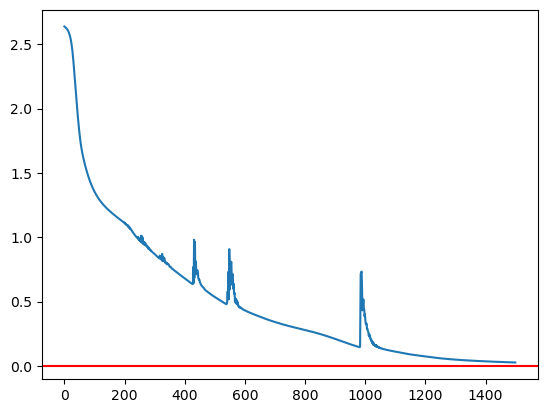

In [9]:
ax = sns.lineplot(metrics['loss'])
_ = ax.axhline(0, color='red')

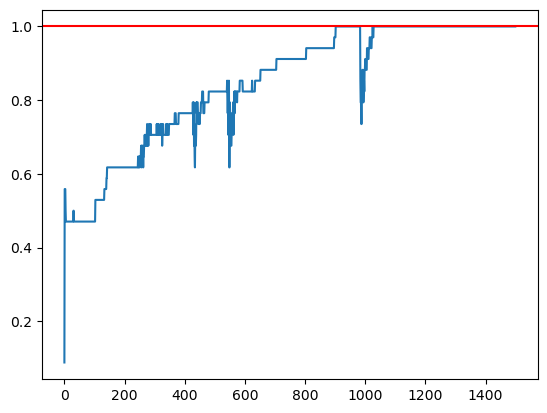

In [10]:
ax = sns.lineplot(metrics['acc'])
_ = ax.axhline(1, color='red')

In [96]:
def eval_encdec_padded(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, device):
    with torch.no_grad():
        outputs = encdec_step(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, device)
    encoder.detach_states()
    decoder.detach_states()
    print(compute_loss(loss, outputs, padded_targets_batch[:, 1:, :]).item())
    print(batch_acc(outputs, padded_targets_batch[:, 1:, :], get_target_vocab_size()).item())
    eval_padded(outputs, padded_targets_batch, padded_samples_batch)

In [113]:
samples_len_c, targets_len_c = samples_len.copy(), targets_len.copy()
eval_encdec_padded(encoder, decoder, padded_samples_batch, padded_targets_batch, samples_len, targets_len, loss, DEVICE)

0.026777997612953186
1.0
print((0+6))############
out: 6eoseos
target: sos6eos#

